# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM, GRU, SimpleRNN, TimeDistributed
from keras.utils import to_categorical
from keras.models import Model
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os


2024-03-14 17:28:56.190608: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 17:28:56.225178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 17:28:56.225210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 17:28:56.225926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 17:28:56.230982: I tensorflow/core/platform/cpu_feature_guar

In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

/home/big/Kevin/Workspace/Homework/ecec147/project/Deep-Learning-EEG-BCI-Signal-Processing/EEG-Data


(2115, 22, 1000)


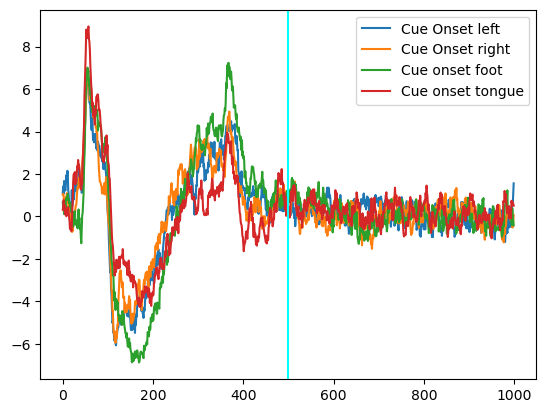

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,9,:]
# ch_data = np.mean(X_train_valid, axis=1)


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [4]:
timesteps = 200

Shape of X after trimming: (443, 22, 400)
Shape of X after maxpooling: (443, 22, 200)
Shape of X after trimming: (250, 22, 400)
Shape of X after maxpooling: (250, 22, 200)
Shape of X after trimming: (1865, 22, 400)
Shape of X after maxpooling: (1865, 22, 200)
Shape of X after averaging+noise and concatenating: (3730, 22, 200)
Shape of X after subsampling and concatenating: (7460, 22, 200)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 200)
Shape of validation set: (250, 22, 200)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7460, 22, 200, 1)
Shape of validation set after adding width info: (250, 22, 200, 1)
Shape of test set after adding width info: (443, 22, 200, 1)
Shape of training set after dimension reshaping: (7460,

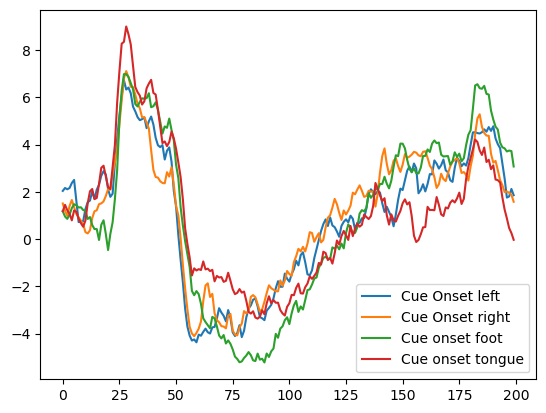

In [5]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:timesteps*sub_sample]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:timesteps*2]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

## Visualizing the data

ch_data = x_train[:,8,:]


class_0_ind = np.where(y_train == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(timesteps),avg_ch_data_class_0)
plt.plot(np.arange(timesteps),avg_ch_data_class_1)
plt.plot(np.arange(timesteps),avg_ch_data_class_2)
plt.plot(np.arange(timesteps),avg_ch_data_class_3)
# plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

# Hybrid Model Architecture

In [6]:
def create_lstm_model(units=32, dropout=0.4, dense=16, reg=1e-3, timesteps=timesteps):
    # Building the model using sequential class
    lstm_model = Sequential()

    # # FC layer
    lstm_model.add(Reshape((timesteps, 22)))
    lstm_model.add(LSTM(units, input_shape=(timesteps,22), return_sequences=True, kernel_regularizer=regularizers.L2(reg))) #dropout=0.4, recurrent_dropout=0.1,
    lstm_model.add(Dropout(dropout))
    # lstm_model.add(LSTM(10, activation='sigmoid', dropout=0.4, recurrent_dropout=0.1, return_sequences=True))
    # lstm_model.add(Dropout(0.2))
    lstm_model.add(TimeDistributed(Dense((dense))))
    # Output layer with Softmax activation 
    lstm_model.add(Flatten())
    lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    lstm_model.build((1, timesteps, 1, 22))
    # Printing the model summary
    # lstm_model.summary()
    return lstm_model

# best_lstm = create_lstm_model(64, 0.1, 8)
# keras.utils.plot_model(best_lstm, to_file="../Gallery/LSTM_architecture_plot.png", show_shapes=True)



In [7]:

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz-10.0.1-win64/bin/'


# Train Hybrid Model

# Retrain most promising model

In [8]:
# Test with regularization

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
learning_rate = 1e-3

lstm_model = create_lstm_model(units=64, reg=0.1, dense=8, dropout=0.5)

lstm_model.compile(loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8,
                        patience=20, min_lr=1e-4)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training and validating the model
lstm_model_results = lstm_model.fit(x_train,
        y_train,
        batch_size=768,
        epochs=50,
        validation_data=(x_valid, y_valid), 
        callbacks=[reduce_lr],
        verbose=True)

score = lstm_model.evaluate(x_test, y_test, verbose=0)
print(score[1])

2024-03-14 17:28:59.333344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 17:28:59.359643: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-14 17:28:59.359862: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2024-03-14 17:29:01.272790: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
2024-03-14 17:29:01.807113: I external/local_xla/xla/service/service.cc:168] XLA service 0x749ae41cc2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 17:29:01.807149: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-14 17:29:01.811571: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710462541.879148   71486 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 [==============================] - 3s 64ms/step - loss: 5.4131 - accuracy: 0.2875 - val_loss: 4.8559 - val_accuracy: 0.3560 - lr: 0.0010
Epoch 2/50
10/10 [==============================] - 0s 32ms/step - loss: 4.6272 - accuracy: 0.3543 - val_loss: 4.2293 - val_accuracy: 0.3880 - lr: 0.0010
Epoch 3/50
10/10 [==============================] - 0s 30ms/step - loss: 3.9334 - accuracy: 0.4405 - val_loss: 3.7084 - val_accuracy: 0.4120 - lr: 0.0010
Epoch 4/50
10/10 [==============================] - 0s 32ms/step - loss: 3.3601 - accuracy: 0.5123 - val_loss: 3.2646 - val_accuracy: 0.4320 - lr: 0.0010
Epoch 5/50
10/10 [==============================] - 0s 36ms/step - loss: 2.8752 - accuracy: 0.5660 - val_loss: 2.8987 - val_accuracy: 0.4440 - lr: 0.0010
Epoch 6/50
10/10 [==============================] - 0s 32ms/step - loss: 2.4735 - accuracy: 0.6114 - val_loss: 2.5821 - val_accuracy: 0.4840 - lr: 0.0010
Epoch 7/50
10/10 [==============================] - 0s 33ms/step - loss: 2.1370 - accur

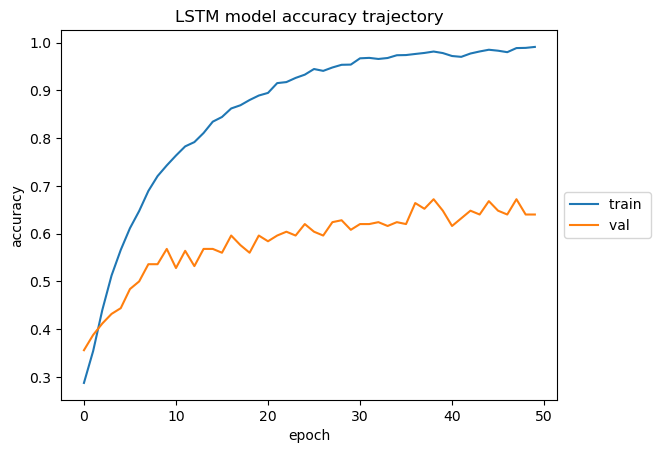

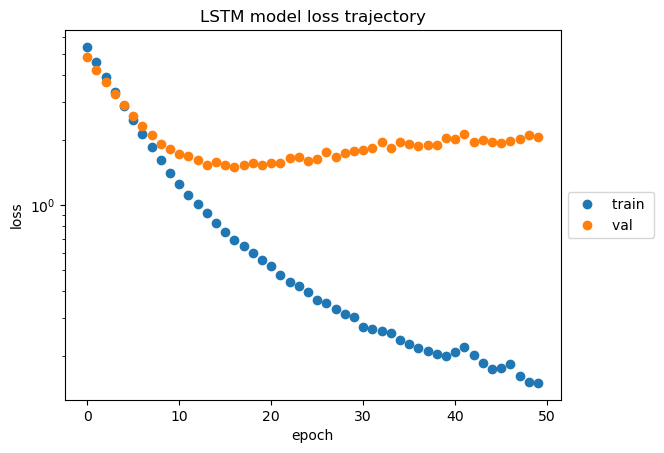

In [9]:
import matplotlib.pyplot as plt

plt.plot(lstm_model_results.history['accuracy'], label="train ")
plt.plot(lstm_model_results.history['val_accuracy'], label="val ")
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
plt.plot(lstm_model_results.history['loss'],'o', label="train ")
plt.plot(lstm_model_results.history['val_loss'],'o', label="val ")
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

8/8 [==============================] - 0s 5ms/step


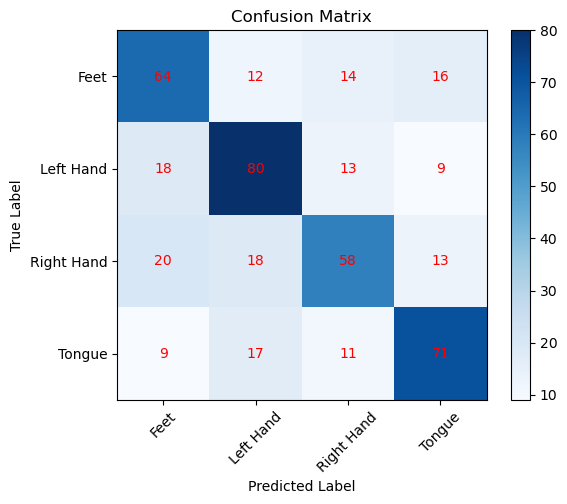

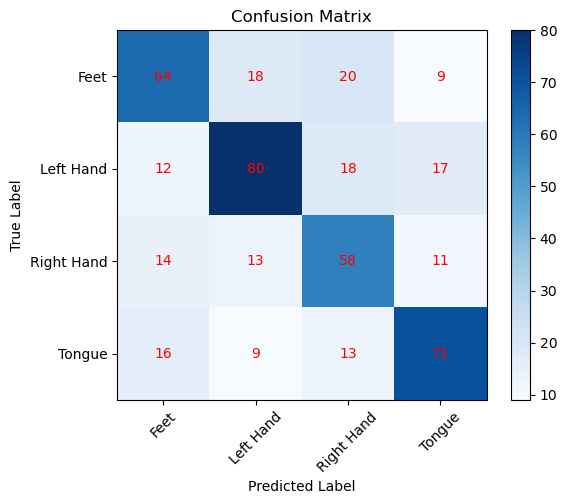

              precision    recall  f1-score   support

           0       0.60      0.58      0.59       111
           1       0.67      0.63      0.65       127
           2       0.53      0.60      0.57        96
           3       0.66      0.65      0.65       109

    accuracy                           0.62       443
   macro avg       0.61      0.62      0.61       443
weighted avg       0.62      0.62      0.62       443



In [10]:
from utils import confusion_matrix

# model = keras.models.load_model('../Models/0_LSTM_0.555304765701294_64_0.1_8_8.h5')
model = lstm_model
y_test_pred = model.predict(x_test)
y_val_pred = model.predict(x_valid)

y_valid_categorical = np.argmax(y_valid, axis=1)
y_val_pred_categorical = np.argmax(y_val_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# y_test_categorical = np.argmax(y_test, axis=1)

# List of class names (adjust as per your dataset)
class_names = ['Feet', 'Left Hand', 'Right Hand', 'Tongue']

# Plot confusion matrix
true_labels = np.argmax(y_test, axis=1)

## Testing 

confusion_matrix.plot_confusion_matrix(y_test_pred_classes, true_labels, class_names, True, '../Gallery/LSTM_confusion_matrix.png')
confusion_matrix.metrics_report(true_labels, y_test_pred_classes)
